In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import random
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import random
import tensorflow as tf
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import BatchNormalization, Activation, Convolution2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, Conv2D

In [3]:
IMG_SIZE = 256
EPOCHS = 250
BATCH_SIZE = 32

In [4]:
# # Set base directory to the current working directory
# base_dir = Path.cwd()

# # Define key directories
# spectrogram_dir = base_dir / 'spectrogram'
# data_dir = base_dir / 'data'
# train_dir = data_dir / 'train'
# test_dir = data_dir / 'test'

# # Create data/train and data/test directories if they do not exist
# for directory in [train_dir, test_dir]:
#     os.makedirs(directory, exist_ok=True)

# # List category subdirectories in the spectrogram directory
# categories = [d for d in spectrogram_dir.iterdir() if d.is_dir()]

# # For each category, split files into train/test and copy them
# for category in categories:
#     files = list(categoriley.glob('*.*'))  # Handles any file extension
#     random.shuffle(files)

#     split_idx = int(len(fs) * 0.8)
#     train_files = files[:split_idx]
#     test_files = files[split_idx:]

#     # Create category subfolders in train/test
#     category_name = category.name
#     os.makedirs(train_dir / category_name, exist_ok=True)
#     os.makedirs(test_dir / category_name, exist_ok=True)

#     # Copy files to train and test directories
#     for f in train_files:
#         shutil.copy(f, train_dir / category_name / f.name)
#     for f in test_files:
#         shutil.copy(f, test_dir / category_name / f.name)

# print("✅ Dataset successfully split into train and test folders.")

In [5]:
base_dir = 'drive/MyDrive/data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [6]:
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

print(class_names)
print(num_classes)

['Animals', 'Exterior', 'Human, non-speech sounds', 'Interior', 'Natural soundscapes & water sounds']
5


In [7]:
class_counts = {}

for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)

  if os.path.isdir(train_dir):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images)

print("\n")
print("Class Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" *45)



Class Distribution:
Class Name               Valid Image Count
Animals                              320
Exterior                             320
Human, non-speech sounds             320
Interior                             320
Natural soundscapes & water sounds            320


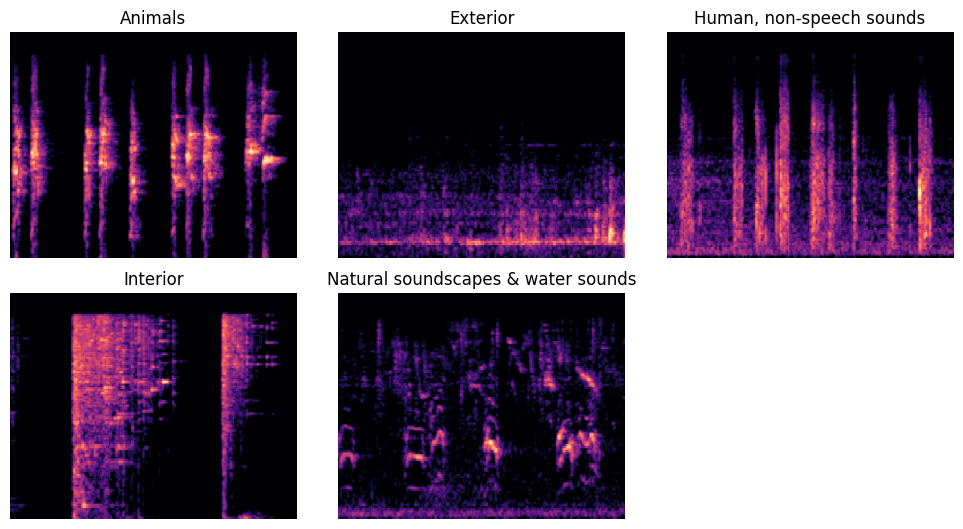

In [8]:
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
  class_dir = os.path.join (train_dir, class_name)
  images = os.listdir(class_dir)
  img_name = random.choice(images)
  img_path = os.path.join(class_dir, img_name)
  img = Image.open(img_path)

  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(class_name)
  plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
corrupted = []
for class_name in class_names:
  class_dir = os.path.join(train_dir, class_name)
  for img_name in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_name)
    try:
      img = Image.open(img_path)
      img.verify()
    except:
      corrupted.append(img_path)
      os.remove(img_path)
      print(f"Removed corrupted image:{img_path}")

if not corrupted:
  print("No corrupted images found.")

No corrupted images found.


In [10]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


# Function to evaluate and plot confusion matrix for a model
def evaluate_model_and_plot_confusion_matrix(model, val_ds, class_names, model_name):
    y_true = []
    y_pred = []

    # Get the true and predicted labels for the validation dataset
    for images, labels in val_ds:
        preds = model.predict(images)
        preds_labels = np.argmax(preds, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds_labels)

    # Plot the confusion matrix for the current model
    plot_confusion_matrix(y_true, y_pred, class_names, model_name)

In [22]:
data_augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [ ]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(np.array(augmented_images[0]).astype("float32")))
    plt.axis("off")

In [23]:
# ------ Integrate the TensorFlow Dataset Code Below ------

# Parameters for resizing and batching
img_height, img_width = IMG_SIZE, IMG_SIZE
batch_size = BATCH_SIZE
validation_split = 0.2

# Rescaling layer to normalize the images
rescale = tf.keras.layers.Rescaling(1./255)

# Creating the training dataset with validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=111
)


# Creating the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='validation',
    seed=111
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

print("✅ Datasets successfully created for training and validation.")

Found 1600 files belonging to 5 classes.
Using 1280 files for training.
Found 1600 files belonging to 5 classes.
Using 320 files for validation.
✅ Datasets successfully created for training and validation.


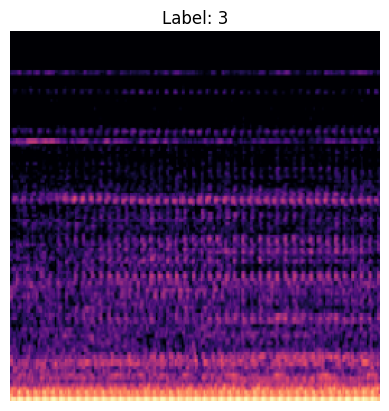

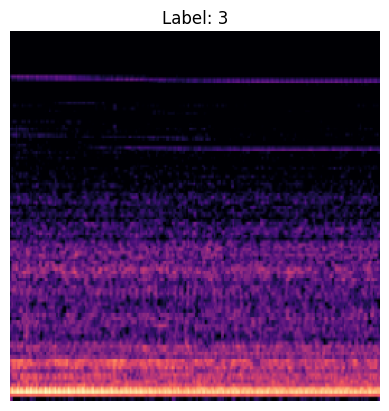

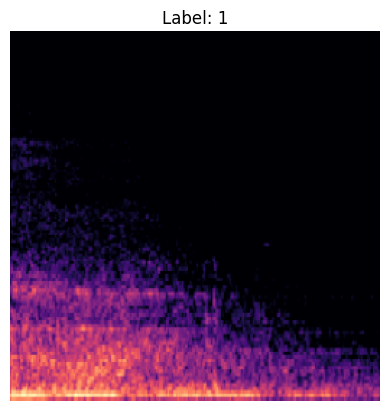

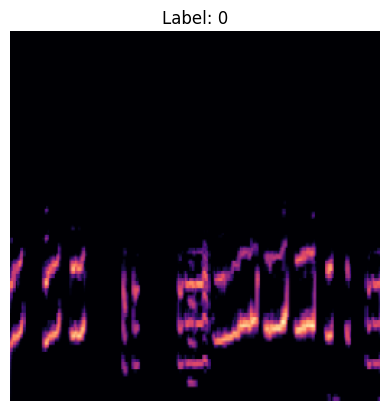

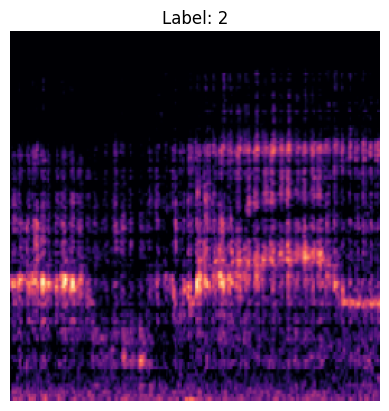

In [24]:
import matplotlib.pyplot as plt

for images, labels in val_ds.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
        plt.show()


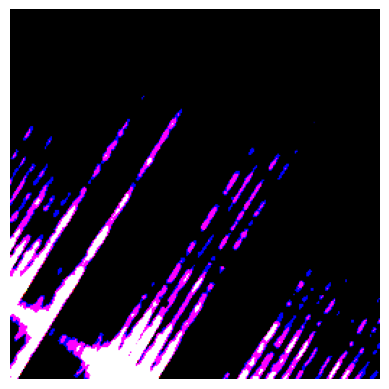

In [25]:
for images, _ in train_ds.take(1):
  plt.imshow(images[0].numpy().astype("float32"))
  plt.axis("off")
  plt.show()

In [29]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),  # Increased L2
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),  # Reduced from 0.25
        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Classifier
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),  # Simplified
        BatchNormalization(),
        Dropout(0.3),  # Reduced from 0.5
        Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 252, 252, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 122, 122, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 59, 59, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 57, 57, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 57, 57, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,135,141 (50.11 MB)

 Trainable params: 13,133,989 (50.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [32]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only = True, monitor = 'val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
]

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 698ms/step - accuracy: 0.3857 - loss: 2.0099 - val_accuracy: 0.2281 - val_loss: 2.2246
Epoch 2/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 676ms/step - accuracy: 0.3866 - loss: 2.0419 - val_accuracy: 0.2313 - val_loss: 2.2707
Epoch 3/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 699ms/step - accuracy: 0.3991 - loss: 1.9299 - val_accuracy: 0.2812 - val_loss: 2.2283
Epoch 4/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 722ms/step - accuracy: 0.4188 - loss: 1.9408 - val_accuracy: 0.3313 - val_loss: 2.2223
Epoch 5/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 695ms/step - accuracy: 0.4300 - loss: 1.9322 - val_accuracy: 0.3469 - val_loss: 2.1687
Epoch 6/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 694ms/step - accuracy: 0.4063 - loss: 1.9025 - val_accuracy: 0.3969 - val_loss: 1.9930
Epoch 7/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 703ms/step - accuracy: 0.4663 - loss: 1.7988 - val_accuracy: 0.3656 - val_loss: 1.9260
Epoch 8/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 736ms/step - accuracy: 0.4657 - loss: 1.8031 - 

In [33]:
# Evaluate CNN model performance
y_true_cnn = []
y_pred_cnn = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_cnn.extend(labels.numpy())
    y_pred_cnn.extend(preds_labels)

# Classification Report for CNN
print("CNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, .labels=range(num_classes), target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
CNN Classification Report:
                                    precision    recall  f1-score   support

                           Animals       0.52      0.38      0.44        69
                          Exterior       0.71      0.59      0.65        68
          Human, non-speech sounds       0.71      0.59      0.65        68
                          Interior       0.52      0.38      0.44        69
Natural soundscapes & water sounds       0.52      0.38      0.44        69

                          accuracy                           0.52      2051
                         macro avg       0.62      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 5
  warnings.warn(


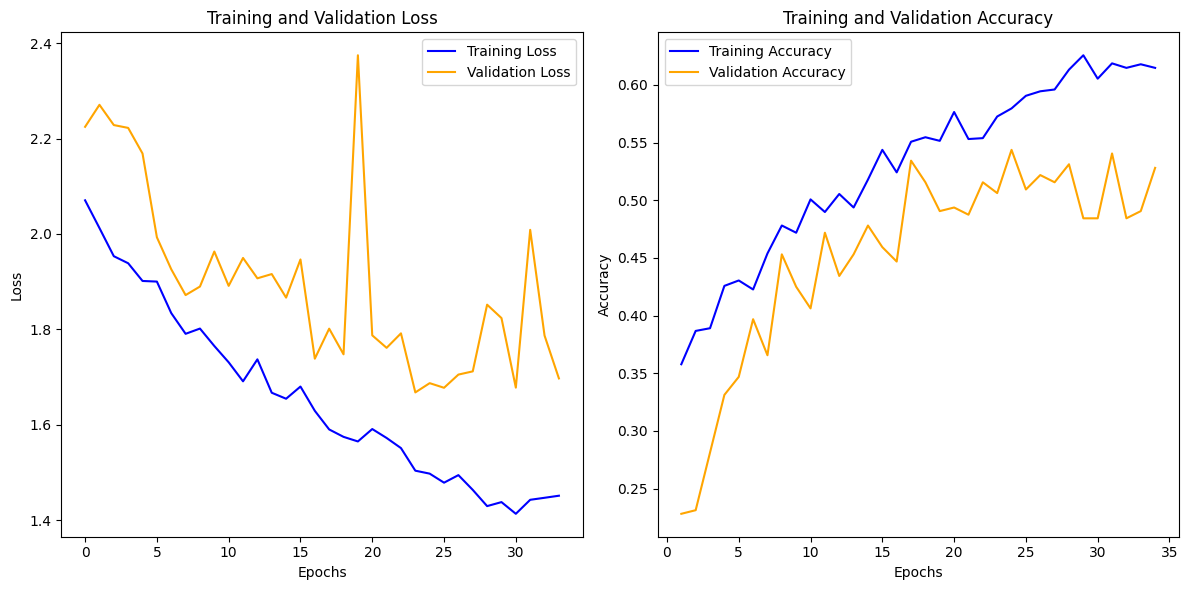

In [34]:
train_loss = history.history ['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
  layer.trainable = False

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

In [39]:
from tensorflow.keras.models import Model
vgg_model = Model(inputs=base_model.input, outputs=x)

In [40]:
from tensorflow.keras.optimizers import Adam

vgg_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_vgg = vgg_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 834ms/step - accuracy: 0.3269 - loss: 3.5552 - val_accuracy: 0.4938 - val_loss: 1.6550
Epoch 2/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 855ms/step - accuracy: 0.4578 - loss: 1.7921 - val_accuracy: 0.6125 - val_loss: 1.0650
Epoch 3/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 771ms/step - accuracy: 0.5635 - loss: 1.1497 - val_accuracy: 0.6438 - val_loss: 0.9655
Epoch 4/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 771ms/step - accuracy: 0.6302 - loss: 1.0082 - val_accuracy: 0.6187 - val_loss: 1.0182
Epoch 5/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 762ms/step - accuracy: 0.6523 - loss: 0.9230 - val_accuracy: 0.6156 - val_loss: 1.0128
Epoch 6/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 782ms/step - accuracy: 0.6552 - loss: 0.8890 - val_accuracy: 0.6156 - val_loss: 0.9724
Epoch 7/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 842ms/step - accuracy: 0.6566 - loss: 0.8720 - val_accuracy: 0.6938 - val_loss: 0.8391
Epoch 8/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 789ms/step - accuracy: 0.6836 - loss: 0.8509 - 

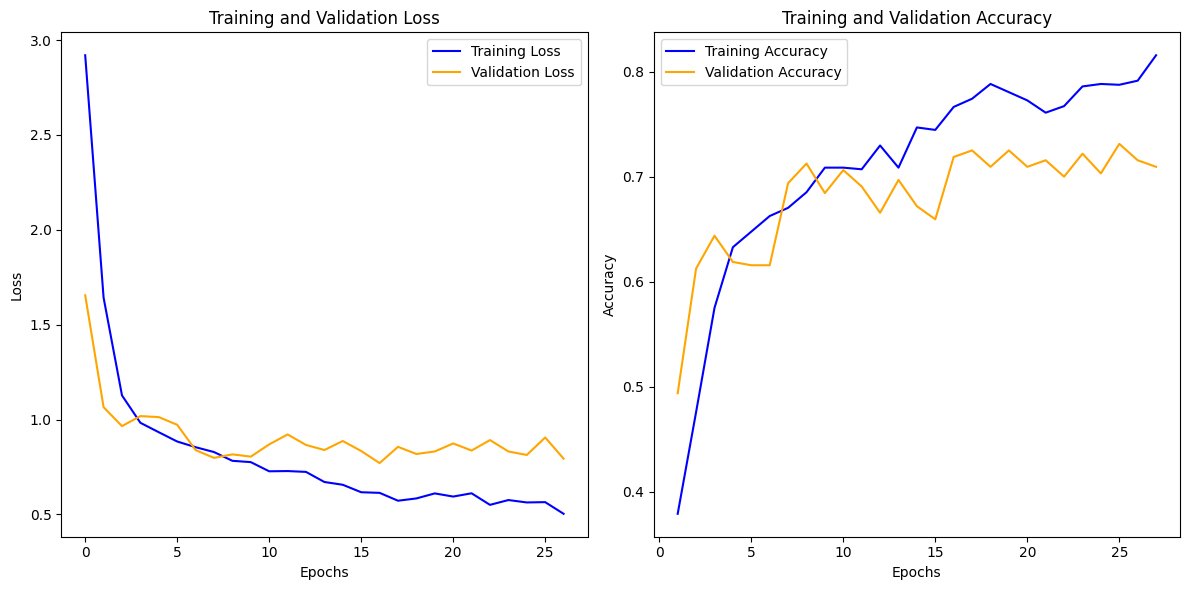

In [41]:
train_loss = history_vgg.history ['loss']
val_loss = history_vgg.history['val_loss']

train_acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# Evaluate VGG16 model performance
y_true_vgg = []
y_pred_vgg = []

for images, labels in val_ds:
    preds = vgg_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_vgg.extend(labels.numpy())
    y_pred_vgg.extend(preds_labels)

# Classification Report for VGG16
print("VGG16 Classification Report:")
print(classification_report(y_true_vgg, y_pred_vgg, .labels=range(num_classes), target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
VGG16 Classification Report:
                                    precision    recall  f1-score   support

                           Animals       0.76      0.75      0.75        59
                          Exterior       0.65      0.62      0.64        69
          Human, non-speech sounds       0.76      0.75      0.75        59
                          Interior       0.65      0.62      0.64        69
Natural soundscapes & water sounds       0.70      0.75      0.73        60

                          accuracy                           0.72      2057
                         macro avg       0.72     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 5
  warnings.warn(


In [43]:
from tensorflow.keras import layers, models

# Define AlexNet architecture
alexnet_model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4, 4), padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(256, (5, 5), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(384, (3, 3), padding='same'),
    layers.Activation('relu'),

    layers.Conv2D(384, (3, 3), padding='same'),
    layers.Activation('relu'),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),
    layers.Dense(4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes),
    layers.Activation('softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
# Compile AlexNet model
alexnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
# Train AlexNet
history_alexnet = alexnet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 725ms/step - accuracy: 0.2147 - loss: 83.2483 - val_accuracy: 0.2844 - val_loss: 1.5681
Epoch 2/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 648ms/step - accuracy: 0.2702 - loss: 1.5501 - val_accuracy: 0.3000 - val_loss: 1.5573
Epoch 3/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 655ms/step - accuracy: 0.2446 - loss: 1.5672 - val_accuracy: 0.3344 - val_loss: 1.5213
Epoch 4/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 685ms/step - accuracy: 0.3048 - loss: 1.5464 - val_accuracy: 0.3594 - val_loss: 1.5016
Epoch 5/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 645ms/step - accuracy: 0.3090 - loss: 1.5191 - val_accuracy: 0.4031 - val_loss: 1.4457
Epoch 6/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 638ms/step - accuracy: 0.3453 - loss: 1.4782 - val_accuracy: 0.3500 - val_loss: 1.4885
Epoch 7/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 650ms/step - accuracy: 0.3541 - loss: 1.4940 - val_accuracy: 0.3781 - val_loss: 1.4096
Epoch 8/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 641ms/step - accuracy: 0.3810 - loss: 1.4518 -

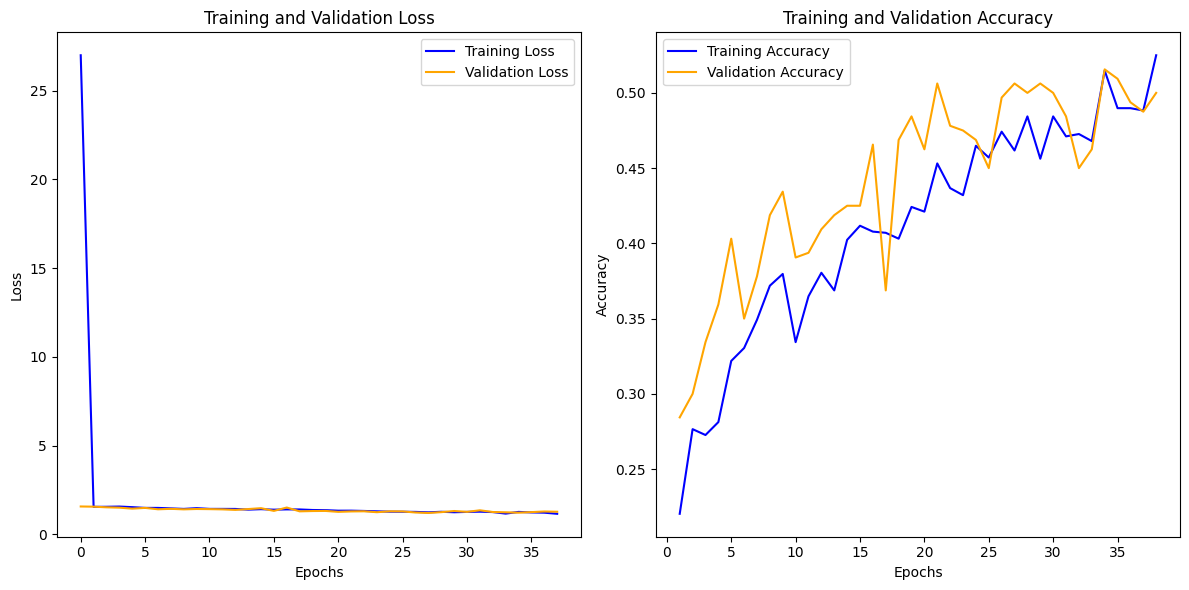

In [46]:
train_loss = history_alexnet.history ['loss']
val_loss = history_alexnet.history['val_loss']

train_acc = history_alexnet.history['accuracy']
val_acc = history_alexnet.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
# Evaluate AlexNet model performance
y_true_alexnet = []
y_pred_alexnet = []

for images, labels in val_ds:
    preds = alexnet_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_alexnet.extend(labels.numpy())
    y_pred_alexnet.extend(preds_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [48]:
vgg_ish_model = tf.keras.Sequential([
    # Convolutional Block 1
    layers.Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 4
    layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(num_classes, activation="softmax")
])

# Compile the VGG-ish model
vgg_ish_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
vgg_ish_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │   134,218,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,431,493 (531.89 MB)

 Trainable params: 139,431,493 (531.89 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train the VGG-ish model
history_vgg_ish = vgg_ish_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

# Evaluate VGG-ish model performance
y_true_vgg_ish = []
y_pred_vgg_ish = []

for images, labels in val_ds:
    preds = vgg_ish_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_vgg_ish.extend(labels.numpy())
    y_pred_vgg_ish.extend(preds_labels)

# Classification Report for VGG-ish
print("VGG-ish Classification Report:")
print(classification_report(y_true_vgg_ish, y_pred_vgg_ish, .labels=range(num_classes), target_names=class_names))


Epoch 1/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6362 - loss: 0.9006 - val_accuracy: 0.5594 - val_loss: 1.1039
Epoch 2/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 975ms/step - accuracy: 0.6197 - loss: 0.9312 - val_accuracy: 0.5406 - val_loss: 1.1233
Epoch 3/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 967ms/step - accuracy: 0.6318 - loss: 0.9535 - val_accuracy: 0.5969 - val_loss: 1.0495
Epoch 4/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6353 - loss: 0.9119 - val_accuracy: 0.5813 - val_loss: 1.0425
Epoch 5/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 971ms/step - accuracy: 0.6376 - loss: 0.9068 - val_accuracy: 0.5750 - val_loss: 1.1174
Epoch 6/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 956ms/step - accuracy: 0.6603 - loss: 0.8494 - val_accuracy: 0.5500 - val_loss: 1.0618
Epoch 7/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 981ms/step - accuracy: 0.6529 - loss: 0.8682 - val_accuracy: 0.5719 - val_loss: 1.0893
Epoch 8/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 994ms/step - accuracy: 0.6709 - loss: 0.8426 - val_ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 5
  warnings.warn(


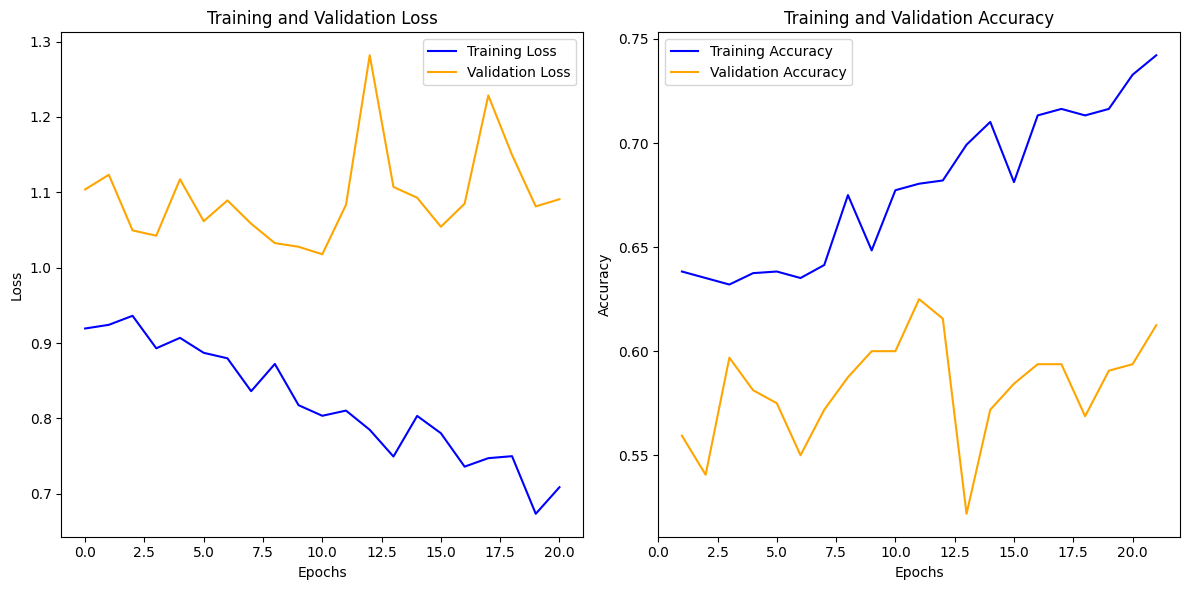

In [53]:
train_loss = history_vgg_ish.history ['loss']
val_loss = history_vgg_ish.history['val_loss']

train_acc = history_vgg_ish.history['accuracy']
val_acc = history_vgg_ish.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
# Evaluate VGG-ish model performance
y_true_vgg_ish = []
y_pred_vgg_ish = []

for images, labels in val_ds:
    preds = vgg_ish_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_vgg_ish.extend(labels.numpy())
    y_pred_vgg_ish.extend(preds_labels)

# Classification Report for VGG-ish
print("VGG-ish Classification Report:")
print(classification_report(y_true_vgg_ish, y_pred_vgg_ish, .labels=range(num_classes), target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
VGG-ish Classification Report:
                                    precision    recall  f1-score   support

                           Animals       0.64      0.65      0.64        60
                          Exterior       0.60      0.69      0.64        68
          Human, non-speech sounds       0.73      0.77      0.75        64
                          Interior       0.73      0.77      0.75        64
Natural soundscapes & water sounds       0.60      0.69      0.64        68

                          accuracy                           0.63      2048
                         macro avg       0.63

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 5
  warnings.warn(


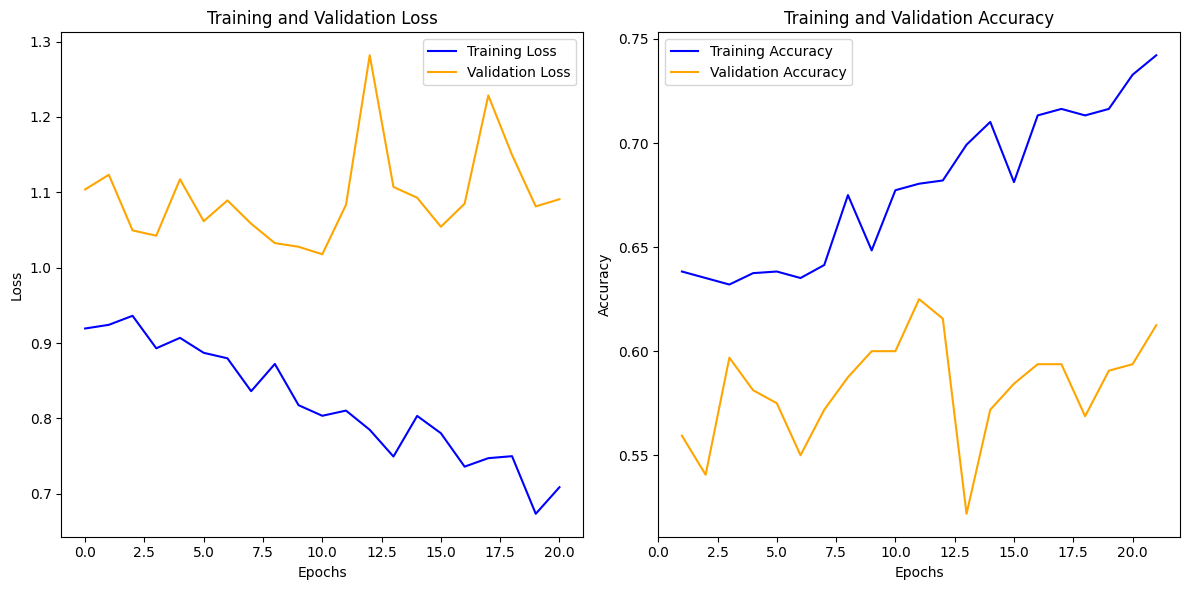

In [55]:
train_loss = history_vgg_ish.history ['loss']
val_loss = history_vgg_ish.history['val_loss']

train_acc = history_vgg_ish.history['accuracy']
val_acc = history_vgg_ish.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
# CNN Metrics
print("CNN Metrics:")
print(classification_report(y_true_cnn, y_pred_cnn, .labels=range(num_classes), target_names=class_names))

# VGG16 Metrics
print("VGG16 Metrics:")
print(classification_report(y_true_vgg, y_pred_vgg, .labels=range(num_classes), target_names=class_names))

# AlexNet Metrics
print("AlexNet Metrics:")
print(classification_report(y_true_alexnet, y_pred_alexnet, .labels=range(num_classes), target_names=class_names))

# VGG-ish Metrics
print("VGG-ish Metrics:")
print(classification_report(y_true_vgg_ish, y_pred_vgg_ish, .labels=range(num_classes), target_names=class_names))


CNN Metrics:
                                    precision    recall  f1-score   support

                           Animals       0.77      0.40      0.53        60
                          Exterior       0.71      0.59      0.65        68
          Human, non-speech sounds       0.43      0.97      0.60        64
                          Interior       0.43      0.97      0.60        64
Natural soundscapes & water sounds       0.71      0.59      0.65        68

                          accuracy                           0.55      2048
                         macro avg       0.62      0.55      0.54      2048
                      weighted avg       0.62      0.55      0.55      2048

VGG16 Metrics:
                                    precision    recall  f1-score   support

                           Animals       0.70      0.75      0.73        60
                          Exterior       0.82      0.72      0.77        68
          Human, non-speech sounds       0.71      0.80 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 5
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 5
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 5
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 5
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


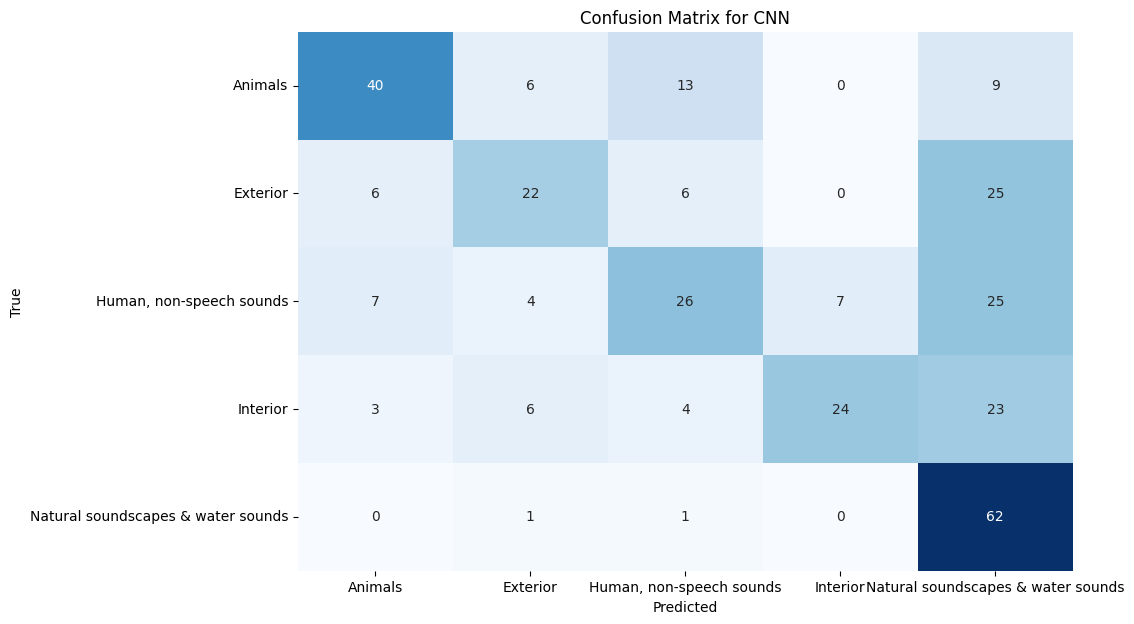

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


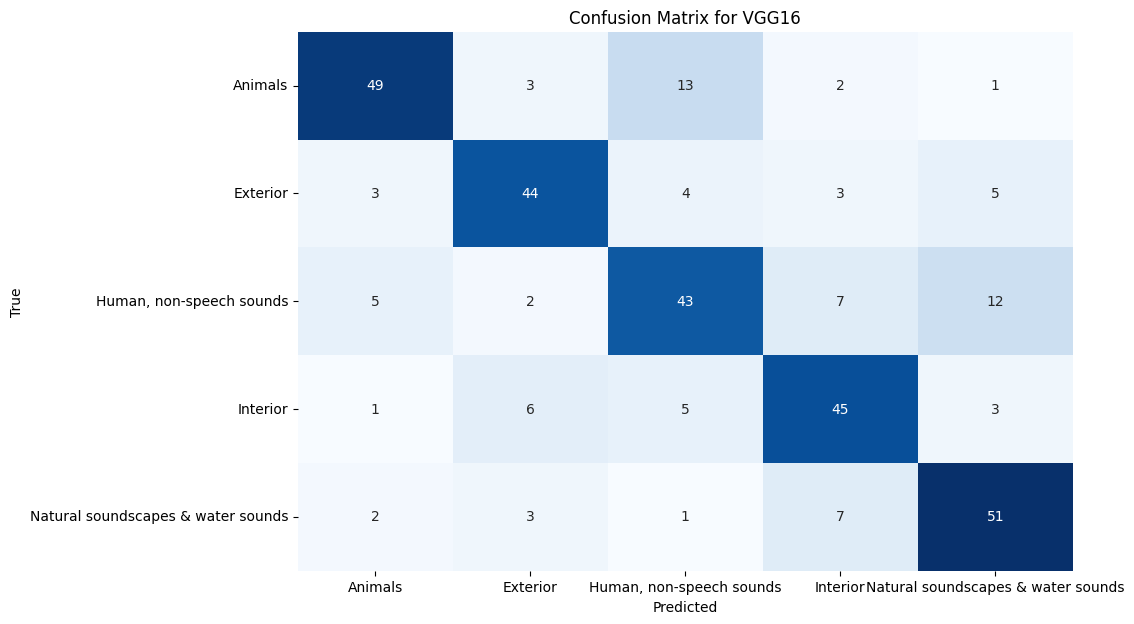

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


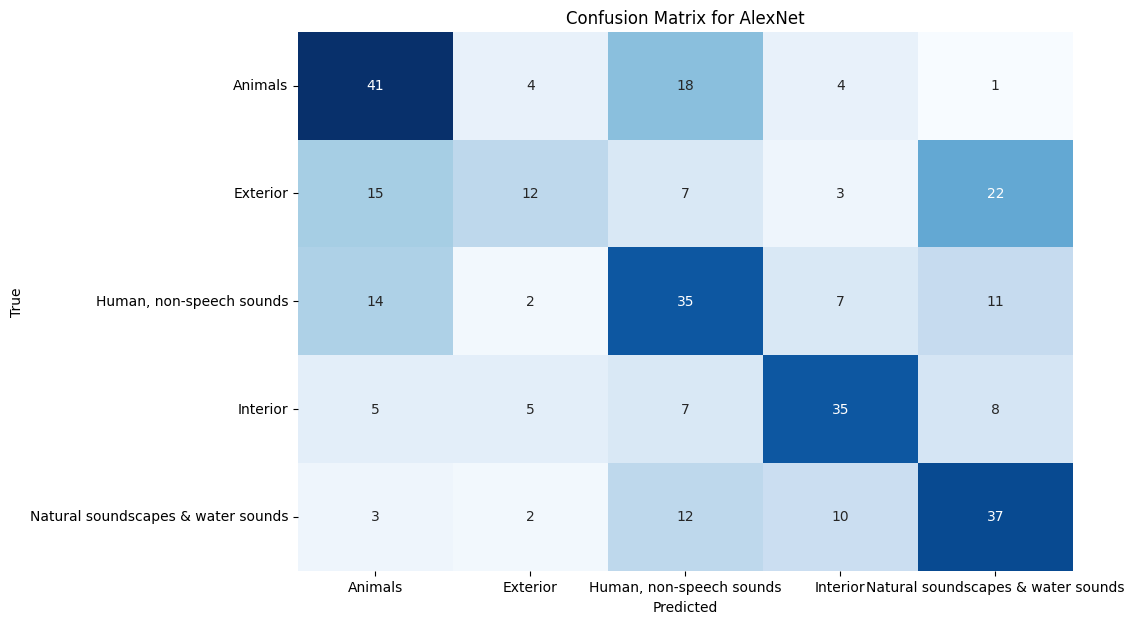

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


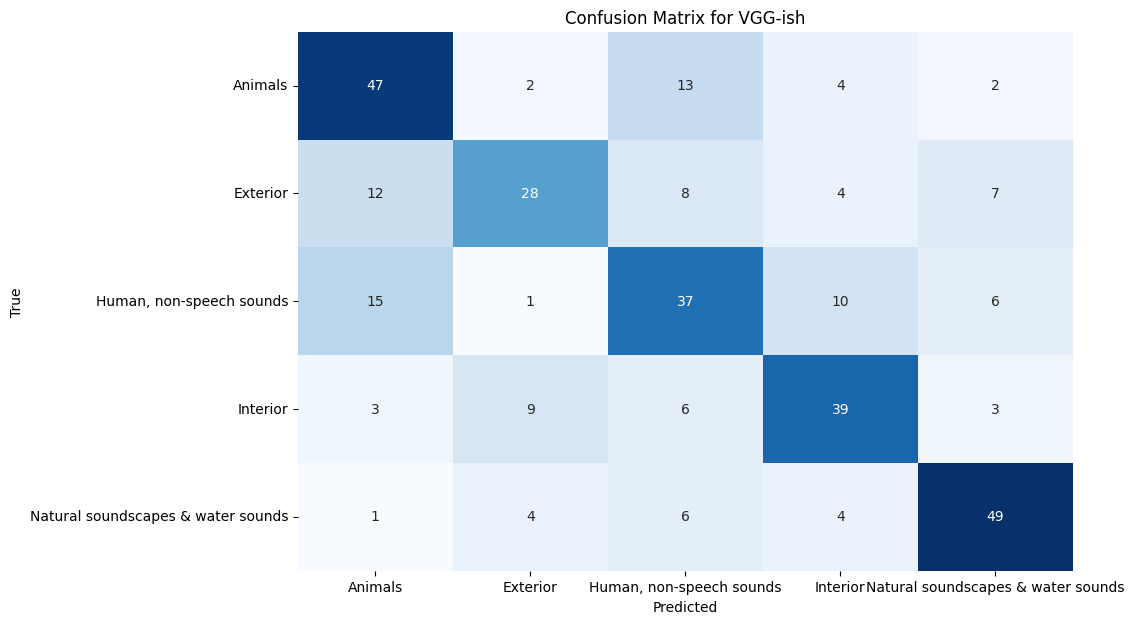

In [57]:
# Evaluate and plot confusion matrix for CNN model
evaluate_model_and_plot_confusion_matrix(model, val_ds, class_names, "CNN")

# Evaluate and plot confusion matrix for VGG16 model
evaluate_model_and_plot_confusion_matrix(vgg_model, val_ds, class_names, "VGG16")

# Evaluate and plot confusion matrix for AlexNet model
evaluate_model_and_plot_confusion_matrix(alexnet_model, val_ds, class_names, "AlexNet")

# Evaluate and plot confusion matrix for VGG-ish model
evaluate_model_and_plot_confusion_matrix(vgg_ish_model, val_ds, class_names, "VGG-ish")